In [41]:
import torch
from torch_geometric.data import Data
import networkx as nx
import os.path as osp
import codecs, json

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv
from torch_geometric.data import (InMemoryDataset, Data)
from torch.autograd import Variable

from tqdm import tqdm, tqdm_gui, tqdm_notebook
from livelossplot import PlotLosses

import pandas as pd

from torch_scatter import scatter_add
from torch_geometric.utils import remove_self_loops, softmax

from torch_geometric.nn.inits import uniform


In [42]:
G_path = '/data_59/huze/MRS/G.multi_dim'
scale = '60'
MRS_path = '/data_59/huze/MRS'

### Data Format Conversion
convert networkx graph to ues torch_geometric

In [43]:
graph_file = osp.join(G_path, 'subj3064_3.scale60.json')
G = nx.node_link_graph(json.load(codecs.open(graph_file, 'r', encoding='utf-8')))

In [44]:
G.nodes[0]

{'NumVert': 1922.0,
 'SurfArea': 1289.0,
 'GrayVol': 3959.0,
 'ThickAvg': 2.673,
 'ThickStd': 0.764,
 'MeanCurv': 0.133,
 'GausCurv': 0.052,
 'StructName': 'lateralorbitofrontal_1'}

In [45]:
def networkx_to_data(G):
    """
    convert a networkx graph to torch geometric data
    """
    # node features
    x = list()
    for i in G.nodes:
        node_feature = [value for key, value in G.nodes[i].items() \
                        if key not in ['StructName', 'FoldInd', 'CurvInd', 'TimeSeries']]
        # append timeseries to node features
#         for t in G.nodes[i]['TimeSeries']:
#             node_feature.append(t)
        x.append(node_feature)
    
    edge_index = list()
    for edge in G.edges:
        edge_index.append(list(edge))
    
    edge_attr = list()
    for edge in edge_index:
        edge_feature = list()
        for key in G[edge[0]][edge[1]].keys():
            edge_feature.append(G[edge[0]][edge[1]][key])
        edge_attr.append(edge_feature)

    x = torch.tensor(x, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


In [46]:
def subj_to_data(data_dir=str, subject_id=str, scale=str):
    """
    given a subject's id and scale, return a Data object to be used in torch_geometric
    """
    graph_file = osp.join(data_dir, 'subj{0}.scale{1}.json'.format(subject_id, scale))
    G = nx.node_link_graph(json.load(codecs.open(graph_file, 'r')))

    data = networkx_to_data(G)
    data.y = torch.tensor(1) if subject_id[0] == '2' else torch.tensor(0)
    # label for patient and non-patient
    
    return data

In [47]:
data = subj_to_data(G_path, '3064_3', '60')

In [48]:
data

Data(edge_attr=[8385, 3], edge_index=[2, 8385], x=[129, 7], y=[])

# Split all subjects into train and test
the same subject won't be in both train and test

In [111]:
p = 0.91

In [112]:
# the same subject won't be in both train and test

from random import shuffle
from itertools import chain, zip_longest

all_subjects = [line.strip() for line in codecs.open(osp.join(MRS_path, 'all_subjects'), 'r').readlines()]
all_subjects.sort()

patient_subject = [s for s in all_subjects if s.startswith('2')]
non_patient_subject = [s for s in all_subjects if s.startswith('3')]
all_subjects = list(filter(None, chain(*zip_longest(patient_subject,non_patient_subject))))

# train_subjects = patient_subject[:int(len(patient_subject) * p)] + \
#                 non_patient_subject[:int(len(non_patient_subject) * p)]
# test_subjects = patient_subject[int(len(patient_subject) * p):] + \
#                 non_patient_subject[int(len(non_patient_subject) * p):]
train_subjects = all_subjects[:int(len(all_subjects) * p)]
test_subjects = all_subjects[int(len(all_subjects) * p):]
# shuffle(train_subjects)
# shuffle(val_subjects)

print("train_subjects: %d" % len(train_subjects))
print(train_subjects)
print("val_subjects: %d" % len(test_subjects))
print(test_subjects)

train_subjects: 150
['2008_1', '3001_3', '2011_3', '3003_3', '2012_1', '3006_1', '2012_3', '3006_3', '2015_1', '3008_1', '2015_3', '3008_3', '2020_1', '3009_1', '2020_3', '3009_3', '2021_1', '3010_1', '2021_3', '3010_3', '2022_1', '3012_1', '2022_3', '3012_3', '2024_1', '3013_1', '2025_1', '3013_3', '2032_3', '3014_1', '2033_1', '3014_3', '2033_3', '3015_1', '2044_3', '3015_3', '2046_1', '3016_1', '2046_3', '3016_3', '2047_1', '3017_1', '2047_3', '3018_1', '2048_1', '3019_1', '2048_3', '3019_3', '2050_1', '3020_1', '2050_3', '3021_1', '2052_1', '3022_1', '2052_3', '3024_1', '2053_1', '3024_3', '2053_3', '3025_1', '2054_1', '3025_3', '2054_3', '3027_1', '2058_1', '3027_3', '2058_3', '3028_1', '2059_1', '3028_3', '2061_1', '3029_1', '2061_3', '3029_3', '2062_1', '3030_1', '2062_3', '3032_1', '2064_1', '3032_3', '2065_3', '3035_1', '2068_1', '3035_3', '2068_3', '3036_1', '2075_1', '3036_3', '2075_3', '3037_1', '2077_3', '3037_3', '2078_3', '3038_1', '2080_3', '3038_3', '2082_1', '3040_1',

In [113]:
def save_subject_list(subject_list, file_path):
    with open(file_path, 'w') as f:
        for x in subject_list:
            f.write(x + '\n')

In [114]:
save_subject_list(train_subjects, osp.join(MRS_path, 'train_subjects'))
save_subject_list(test_subjects, osp.join(MRS_path, 'test_subjects'))

# Calculate mean & std for train/validation set
different mean/std for train/test normalization

In [115]:
def mean_and_std_for_subjects(subject_list, scale):
    datas = [subj_to_data(G_path, s, scale) for s in subject_list]
    # a sample data to get num_features
    data = datas[0]
    num_features = data.num_features
    
    datas = [data.x for data in datas]
    datas = torch.stack(datas)
    
    mean, std = [], []
    for i in range(0, num_features):
        features = datas[:, :, i].view(-1)
        mean.append(features.mean().item())
        std.append(features.std().item())
    
    return mean, std

In [116]:
train_subject = [line.strip() for line in codecs.open(osp.join(MRS_path, 'train_subjects'), 'r').readlines()]
train_mean, train_std = mean_and_std_for_subjects(train_subject, scale)
test_subjects = [line.strip() for line in codecs.open(osp.join(MRS_path, 'test_subjects'), 'r').readlines()]
test_mean, test_std = mean_and_std_for_subjects(test_subjects, scale)

In [117]:
print(train_mean)
print(train_std)
print(test_mean)
print(test_std)

[2092.202880859375, 1467.216796875, 4256.30322265625, 2.5251529216766357, 0.7080460786819458, 0.13764184713363647, 0.03913106396794319]
[983.1158447265625, 670.9742431640625, 1944.073974609375, 0.3271346986293793, 0.11803543567657471, 0.018789958208799362, 0.01337816659361124]
[2085.7890625, 1468.462890625, 4397.27490234375, 2.5623159408569336, 0.696068286895752, 0.13728415966033936, 0.03779979050159454]
[872.685546875, 609.8560791015625, 1902.5167236328125, 0.3120511472225189, 0.1075952872633934, 0.018359433859586716, 0.012635496445000172]


# Set missing data (Subcortical) to mean value for train/test

In [118]:
def read_graph_by_subject(G_path, subject, scale):
    subject_G_path = osp.join(G_path, 'subj{0}.scale{1}.json'.format(subject, scale))
    G = nx.node_link_graph(json.load(codecs.open(subject_G_path, 'r')))
    return G

In [119]:
def _set_missing_data(G, mean):
    """
    Args: 
        mean: list of tensor
    """
    for node in G.nodes:
        if G.nodes[node]['StructName'] == 'SubCortical':
            for i, (k, v) in enumerate(G.nodes[node].items()):
                if k not in ['StructName', 'TimeSeries']: # Skip TimeSeries
                    G.nodes[node][k] = mean[i]

In [120]:
def set_missing_data(subject_list, G_path, scale, mean):
    for subject in subject_list:
        subject_G_path = osp.join(G_path, 'subj{0}.scale{1}.json'.format(subject, scale))
        G = nx.node_link_graph(json.load(codecs.open(subject_G_path, 'r')))
        _set_missing_data(G, mean)
        json_graph = nx.node_link_data(G)
        json.dump(json_graph, codecs.open(subject_G_path, 'w', encoding='utf-8'), separators=(',', ':'),
                 indent=4)

In [121]:
set_missing_data(train_subject, G_path, scale, train_mean)
set_missing_data(val_subject, G_path, scale, val_mean)

# Plot node features distrubution


In [122]:
def plot_node_feature(subjects):
    datas = [subj_to_data(G_path, s, scale) for s in subjects]
    datas = [data.x for data in datas]
    datas = torch.stack(datas)
    for i in range(0, 7): # 7 features without timeseries
        all_features = datas[:, :, i]
        plt.hist(all_features)
        plt.show()

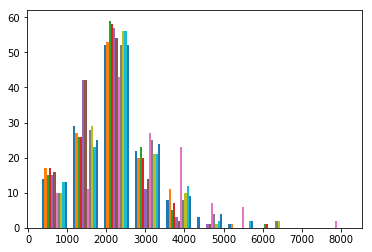

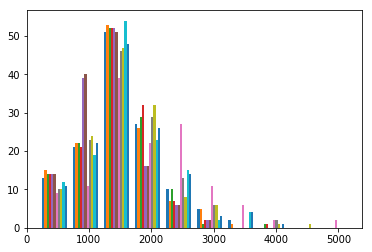

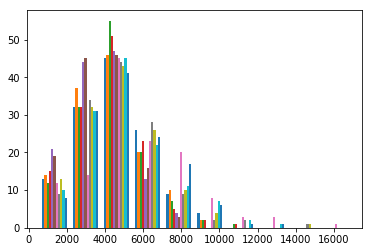

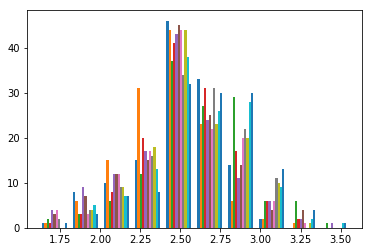

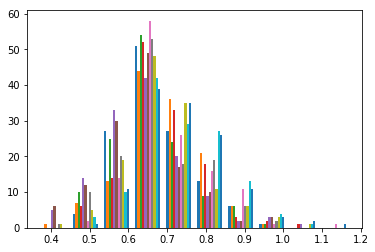

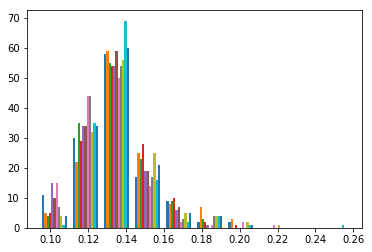

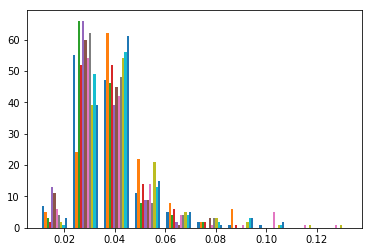

In [123]:
plot_node_feature(val_subject)

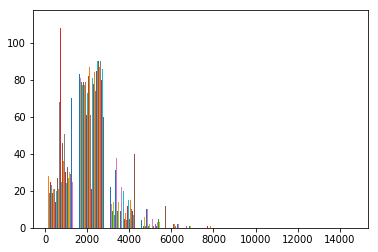

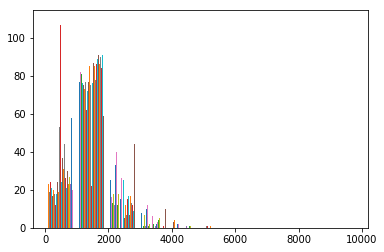

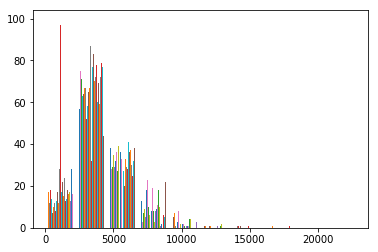

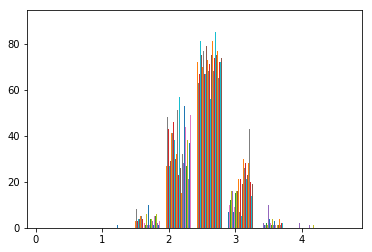

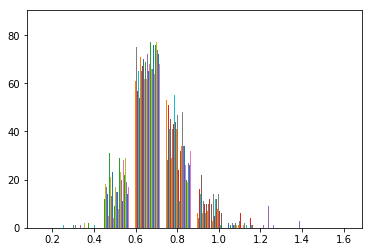

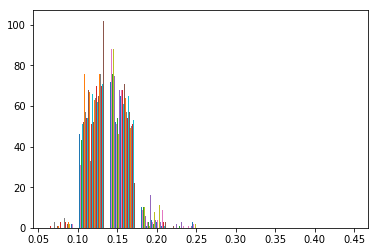

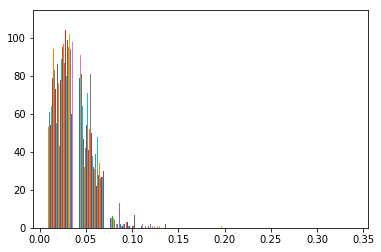

In [124]:
plot_node_feature(train_subject)